In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import scipy.io
import time
#from progress.bar import Bar

sns.set()
sns.set_style("white")

%matplotlib inline


## Simulation module implementation

### Description of the simulation module

At a high level, the simulation alternates between two states which is encoded by a variable `s`. In the setup, `u` and `v` are two neurons that mutually inhibit each other according to this dynamics:

$$ \tau\frac{du}{dt} = -u + \theta \ (W_{uI}I - W_{uv}v - sI_F)$$

Similarly for $v$,

$$ \tau\frac{dv}{dt} = -v + \theta \ (W_{vI}I - W_{vu}u + sI_F)$$

$y$ and $z$ are read-out neurons. $y$ measures the difference between $u$ and $v$ and $z$ measures the deviation of $y$ from the threshold $y_0$.

$$ \tau\frac{dy}{dt} = -y + u - v $$

The global state is given by $s$ which is an external signal. This state alternates between two modes:

* When $s = 0$, the network operates in *integration* mode
    - $v$ receives an impulse $I_p = 50$, for a duration of one time steps. After that $I_p = 0$.
    - $I$ remains constant (gated out, uncoupled from $y$)


* When $s = 1$, the network operates in *update* mode
    - $I_p$ continues to be 0.
    - $I$ gets coupled to $y$.
    
    
In particular, $ \tau\frac{dI}{dt} = sK(y-y_0)  $

In [2]:
PARAMS_DICT = {'Wut': 6,
              'Wuv': 6,
              'Wvt': 6,
              'Wvu': 6,
              'dt': 10,
              'tau': 100,
              'ext': 0,
              'y0': 0.7,
              'IF': 100,
              'uinit': 0.7,
              'vinit': 0.2,
              'yinit': 0.5}

In [3]:
def thresh_exp(x):
    '''Sigmoid non-linearity'''
    return 1 / (1 + np.exp(-x))

def start_simulation_parallel(state_init, params, K, sigma, niter):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wuv']
    Wvt = params['Wvt']
    Wvu = params['Wvu']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    IF = params['IF']
    
    # Unpack variables
    I, u, v, y, sig = state_init
    
    ntrials = len(I)
    
    I = I.copy()
    u = u.copy()
    v = v.copy()
    y = y.copy()
        
    sig_lst = []
    u_lst = []
    v_lst = []
    y_lst = []
    I_lst = []
    
    for i in range(niter):                
        # Update I, u, v and y
        I += (sig * K * (y - y0)) / tau * dt
        u += (-u + thresh_exp(Wut * I - Wuv * v - sig * IF + np.random.randn(ntrials) * sigma)) / tau * dt
        v += (-v + thresh_exp(Wvt * I - Wvu * u + sig * IF + np.random.randn(ntrials) * sigma)) / tau * dt
        y += (-y + u - v + np.random.randn(ntrials) * sigma) / tau * dt

        v_lst.append(v.copy())
        u_lst.append(u.copy())
        y_lst.append(y.copy())
        I_lst.append(I.copy())
        sig_lst.append(sig)    
        
    return u_lst, v_lst, y_lst, I_lst, sig_lst

In [4]:
def plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, params_dict):
    '''Plot the simulations'''
    dt = params_dict['dt']
    nsteps = len(ulst)
    tlst = np.arange(nsteps).astype('int')
    sig_lst = np.floor(tlst / 100) % 2
    sig_lst = sig_lst.astype('int')
    
    ulst_arr = np.array(ulst)
    vlst_arr = np.array(vlst)
    ylst_arr = np.array(ylst)
    Ilst_arr = np.array(Ilst)
    
    wherelst = np.array(siglst) == 1.0
    wherelst_shifted = np.concatenate((wherelst[1:], [False]))
    wherelst += wherelst_shifted
    
    #wherelst2 = np.array(siglst) == 2.0

    fig, ax = plt.subplots(4, 1, figsize=(10, 10))
    ax[0].plot(np.arange(nsteps) * dt, ulst_arr, 'b', alpha=0.2)
    ax[0].set_ylabel('u')
    ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst, alpha=0.5)
    #ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst2, alpha=0.2)

    ax[1].plot(np.arange(nsteps) * dt, vlst_arr, 'b', alpha=0.2)
    ax[1].set_ylabel('v')
    ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst, alpha=0.5)
    #ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst2, alpha=0.2)

    ax[2].plot(np.arange(nsteps) * dt, ylst_arr, 'b', alpha=0.2)
    ax[2].set_ylabel('y')
    ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst, alpha=0.5)
    #ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst2, alpha=0.2)
    ax[2].hlines(PARAMS_DICT['y0'], 0, nsteps * dt, linestyle='dotted')

    ax[3].plot(np.arange(nsteps) * dt, Ilst_arr, 'b', alpha=0.2)
    ax[3].set_ylabel('I')
    ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst, alpha=0.5)
    #ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst2, alpha=0.2)
    ax[3].set_xlabel('Time (ms)');

In [5]:
# Functions for using in a for loop
def get_times_lst_from_y(ylst):
    '''
    Input:
    - ylst: np array of y activations
    
    Output:
    A 1d array of the times to threshold of the last behavior
    '''
    
    ndiscard = 10
    threshold = PARAMS_DICT['y0']
    # Discard first 10 samples
    ylst = ylst[ndiscard:]
    times_lst = []
    ntrials = ylst.shape[1]
    
    # Find time to act
    for k in range(ntrials):
        # Check if the bound is reached (sometimes it's not!)
        if np.max(ylst[:,k]) > threshold:
            times_lst.append(np.nonzero(ylst[:, k] > threshold)[0][0])
        else:
            times_lst.append(np.inf)
            #print('Bound not reached')
    
    return np.array(times_lst) + ndiscard

def simulate_trial(ntrials=1000, duration=600, nstages=10, sigma=0, K=3.0, initI=0.7):
    # Initial run
    #ntrials = 1000
    #duration = 600 #ms
    #nstages = 10
    PARAMS_DICT['sigma'] = sigma
    PARAMS_DICT['K'] = K
    first_duration = 750 #duration in ms of first duration (500 ms + exponential with mean 250)
    
    nbin = int(duration / PARAMS_DICT['dt'])
    nbinfirst = int(first_duration / PARAMS_DICT['dt'])
    
    uinit = PARAMS_DICT['uinit']
    vinit = PARAMS_DICT['vinit']
    yinit = PARAMS_DICT['yinit']

    state_init = [np.ones(ntrials) * initI, 
                  np.ones(ntrials) * uinit, 
                  np.ones(ntrials) * vinit,
                  np.ones(ntrials) * yinit,
                  0.0]

    ulst, vlst, ylst, Ilst, siglst = start_simulation_parallel(state_init, PARAMS_DICT, 0, sigma, nbinfirst)

    # For subsequent runs, flip the state every 100 trials
    for k in range((nstages - 2) * 2):
        #acoefs = 1 - acoefs
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        if state_init[4] == 0.0:
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, K, sigma, nbin)
        else:
            if k == 0:
                # No update for first flash
                ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 0, sigma, 1)
            else:
                ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, K, sigma, 1)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        siglst += siglst2

    if nstages > 1:
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        # For the last run, produce the behavior when the threshold is reached
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, K, sigma, 1)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        siglst += siglst2
        
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        # For the last run, produce the behavior when the threshold is reached
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, K, sigma, nbin * 2)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        
        siglst2[nbin] = 1
        siglst += siglst2
    else:
        print(len(siglst))
        siglst[-1] = 1
        ylst2 = ylst

    return ulst, vlst, ylst, Ilst, siglst, ylst2


def get_time_lst(ntrials=1000, duration=600, nstages=10, sigma=0, K=3.0, initI=0.7):
    '''Simulate and return the array of times of threshold crossing'''
    _, _, _, _, _, ylst2 = simulate_trial(ntrials=ntrials, nstages=nstages, duration=duration, 
                                                                       sigma=sigma, K=K, initI=initI)
    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2))
    times = times[(times > 0) & (times != np.inf)]
    return times

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean decision time is  nan


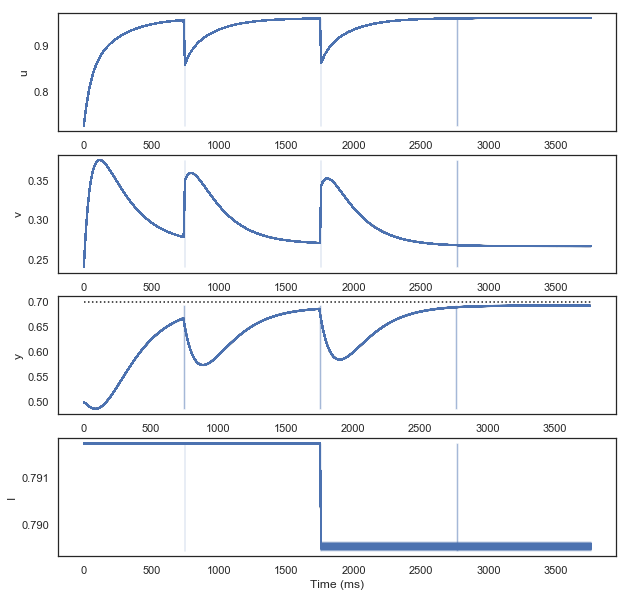

In [14]:
sigma = 0.001
I = 0.7917359631578601
K = 1.5348190751143918
duration = 1000

#ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(nstages=3, sigma=sigma, K=K, initI=0.766)
np.random.seed(2018)
ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=300, nstages=3, duration=duration, sigma=sigma, 
                                                       K=K, initI=I)
plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, PARAMS_DICT)

Ylst2 = np.array(ylst2)
times = get_times_lst_from_y(np.array(Ylst2))
times = times[(times > 0) & (times != np.inf)]
print('Mean decision time is ', np.mean(times))

# Save the parameters in a .mat file
#scipy.io.savemat('PlotTools/uv_simulation_data012619_K3_164_I0_7825_s0_0136_1000ms.mat', {'ulst': ulst, 'vlst': vlst, 'ylst': ylst, 
#                                                  'Ilst': Ilst, 'siglst': siglst, 'PARAMS': PARAMS_DICT,
#                                                   'sigma': sigma, 'K': K, 'I': I})

## Optimizing over a single ISI

In [ ]:
#TODO: function to find I that hits the correct interval in 1 iteration..(?)

In [8]:
np.random.seed(123)
Klst = np.linspace(0, 4, 20)
sigma_lst = np.linspace(0.01, 0.1, 6)

meanlst = np.zeros((len(sigma_lst), len(Klst)))
varlst = np.zeros((len(sigma_lst), len(Klst)))

duration = 600

for i in range(len(sigma_lst)):
    for j in range(len(Klst)):
        sigma = sigma_lst[i]
        K = Klst[j]
        print('Working on K = ', K)
        ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=20000, nstages=3, 
                                                               duration=duration, sigma=sigma, K=K, initI=0.84)
        times = get_times_lst_from_y(np.array(ylst2))
        times_filt = times[(times > 0) & (times != np.inf)]
        
        if len(times_filt) < len(times):
            print('inf encountered')
            meanlst[i][j] = np.NAN
            varlst[i][j] = np.NAN
        else:
            meanlst[i][j] = np.mean(times)
            varlst[i][j] = np.std(times)

Working on K =  0.0
Working on K =  0.21052631578947367
Working on K =  0.42105263157894735
Working on K =  0.631578947368421
Working on K =  0.8421052631578947
Working on K =  1.0526315789473684
Working on K =  1.263157894736842
Working on K =  1.4736842105263157
Working on K =  1.6842105263157894
Working on K =  1.894736842105263
Working on K =  2.1052631578947367
Working on K =  2.3157894736842106
Working on K =  2.526315789473684
Working on K =  2.7368421052631575
Working on K =  2.9473684210526314
Working on K =  3.1578947368421053
Working on K =  3.3684210526315788
Working on K =  3.578947368421052
Working on K =  3.789473684210526
Working on K =  4.0
Working on K =  0.0
Working on K =  0.21052631578947367
Working on K =  0.42105263157894735
Working on K =  0.631578947368421
Working on K =  0.8421052631578947
Working on K =  1.0526315789473684
Working on K =  1.263157894736842
Working on K =  1.4736842105263157
Working on K =  1.6842105263157894
Working on K =  1.894736842105263


Text(0, 0.5, '$\\sigma$')

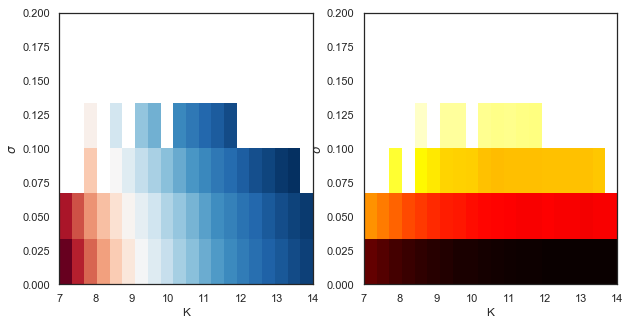

In [9]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.flipud((meanlst - 60)), cmap='RdBu_r', extent=[7, 14, 0, 0.2], aspect='auto')
plt.xlabel('K')
plt.ylabel(r'$\sigma$')

plt.subplot(1, 2, 2)
plt.imshow(np.flipud(varlst), extent=[7, 14, 0, 0.2], cmap='hot', aspect='auto')
plt.xlabel('K')
plt.ylabel(r'$\sigma$')

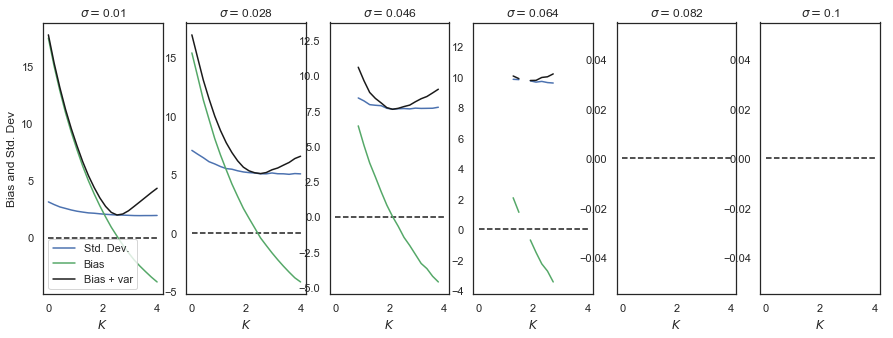

In [10]:
rmselst = np.sqrt((meanlst - 60) ** 2 + varlst**2)

fig, ax = plt.subplots(1, 6, figsize=(15, 5))
for i in range(6):
    sq_bias = (meanlst[i]-400)**2
    biasid = np.argmin(sq_bias)
    varid = np.argmin(varlst[i])
    ax[i].plot(Klst, varlst[i], color='b', label='Std. Dev.')
    ax[i].plot(Klst, meanlst[i] - 60, color='g', label='Bias')
    ax[i].plot(Klst, rmselst[i], color='k', label='Bias + var')
    #ax[i].set_ylim((-5, 10))
    ax[i].set_xlabel(r'$K$')
    ax[i].set_title(r'$\sigma=$' + str(np.round(sigma_lst[i], 3)))
    ax[i].hlines(0, min(Klst), max(Klst), linestyles='--')
    #ax[i-1].axvline(x=Klst[biasid], linestyle='--', color='g')
    #ax[i-1].axvline(x=Klst[varid], linestyle='--', color='b')

ax[0].set_ylabel('Bias and Std. Dev')
ax[0].legend(loc='lower left');
#save_safe('bias_variance_sigma_sigma.pdf')

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


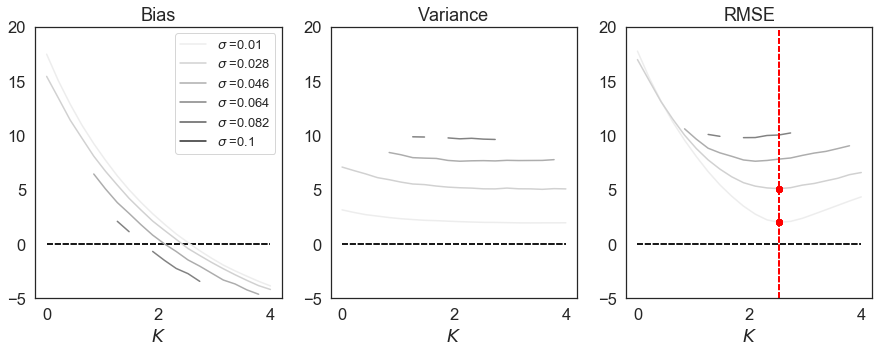

In [11]:
sns.set(font_scale=1.5)
sns.set_style('white')

colorsR = sns.color_palette('OrRd', 6)
colorsB = sns.color_palette('Blues', 6)
colorsG = sns.color_palette('Greys', 6)

rmsemins = np.min(rmselst, axis=1)
rmseargmins = np.argmin(rmselst, axis=1)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(6):
    sq_bias = (meanlst[i]-400)**2
    biasid = np.argmin(sq_bias)
    varid = np.argmin(varlst[i])
    #ax[0].plot(Klst, varlst[i], color='b', label='Std. Dev.')
    ax[0].plot(Klst, meanlst[i] - 60, color=colorsG[i], 
               label=r'$\sigma$ =' + str(np.round(sigma_lst[i], 3)))
    #ax[0].plot(Klst, np.sqrt((meanlst[i] - 60) ** 2 + varlst[i]**2), color='k')
    ax[0].set_ylim((-5, 20))
    ax[0].set_xlabel(r'$K$')
    ax[0].set_title('Bias')
    ax[0].hlines(0, min(Klst), max(Klst), linestyles='--')
    #ax[i-1].axvline(x=Klst[biasid], linestyle='--', color='g')
    #ax[i-1].axvline(x=Klst[varid], linestyle='--', color='b')
    
for i in range(6):
    sq_bias = (meanlst[i]-400)**2
    biasid = np.argmin(sq_bias)
    varid = np.argmin(varlst[i])
    ax[1].plot(Klst, varlst[i], color=colorsG[i])
    #ax[1].plot(Klst, meanlst[i] - 60, color='g', label='Bias')
    #x[1].plot(Klst, np.sqrt((meanlst[i] - 60) ** 2 + varlst[i]**2), color='k')
    ax[1].set_ylim((-5, 20))
    ax[1].set_xlabel(r'$K$')
    ax[1].set_title('Variance')
    ax[1].hlines(0, min(Klst), max(Klst), linestyles='--')
    #ax[i-1].axvline(x=Klst[biasid], linestyle='--', color='g')
    #ax[i-1].axvline(x=Klst[varid], linestyle='--', color='b')
    
for i in range(6):
    sq_bias = (meanlst[i]-400)**2
    biasid = np.argmin(sq_bias)
    varid = np.argmin(varlst[i])
    #ax[0].plot(Klst, varlst[i], color='b', label='Std. Dev.')
    #ax[0].plot(Klst, meanlst[i] - 60, color='g', label='Bias')
    ax[2].plot(Klst, rmselst[i], color=colorsG[i])
    ax[2].set_ylim((-5, 20))
    ax[2].set_xlabel(r'$K$')
    ax[2].set_title('RMSE')
    ax[2].hlines(0, min(Klst), max(Klst), linestyles='--')
    #ax[2].plot(Klst[rmseargmins], rmsemins, '--', color=[1,0,0])
    ax[2].plot(Klst[rmseargmins], rmsemins, 'o', color=[1,0,0])
    ax[2].axvline(x=Klst[rmseargmins[0]], linestyle='--', color=[1,0,0])
    #ax[i-1].axvline(x=Klst[varid], linestyle='--', color='b')

#ax[0].set_ylabel('Bias and Std. Dev')
ax[0].legend(loc='upper right',
               prop={'size': 13});
plt.savefig('bias_variance_rmse_by_sigma.pdf')

## Optimizing over a prior

### Ready, Set, Go task

Our prior will be a discrete uniform distribution 600, 700, ..., 1000 ms.

We simulate the 1-2-Go and 1-2-3-Go tasks below and calculate the MSE landscape. $(I, K)$ will be sampled from a grid of values.

In [30]:
# Trial duration is uniformly sampled from in [600, 1000]
durations = np.linspace(600, 1000, 5)

prod_time_lst = []
prod_var_lst = []

sigma_lst = np.linspace(0.005, 0.03, 6)

nK = 10
nI = 10
Klst = np.linspace(2, 3.5, nK)
initIlst = np.linspace(0.83, 0.86, nI)
MSELST = []

for id_s, sigma in enumerate(sigma_lst):
    print('*** sigma = ', sigma, ' ***')
    mse_lst = np.zeros((nI, nK))
    for i, I in enumerate(initIlst):
        for j, K in enumerate(Klst):
            #print('I = ', I, 'K = ', K)
            mse_total = 0
            for k, dur in enumerate(durations):
                #print('Doing time #', i, '=', time)

                ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=3, 
                                                                       duration=dur, sigma=sigma, K=K, initI=I)

                Ylst2 = np.array(ylst2)
                times = get_times_lst_from_y(np.array(Ylst2))
                times = times[(times > 0) & (times != np.inf)]

                mse_total += np.sum((times * 10 - time)**2)

            mse_lst[i][j] = mse_total
            print('I = ', I, 'K = ', K, 'Total MSE = ', np.sqrt(np.mean(mse_total)))
    MSELST.append(mse_lst)
    

*** sigma =  0.005  ***
I =  0.83 K =  2.0 Total MSE =  13747.465220905271
I =  0.83 K =  2.1666666666666665 Total MSE =  13247.067600038885
I =  0.83 K =  2.3333333333333335 Total MSE =  12741.153793907364
I =  0.83 K =  2.5 Total MSE =  12228.691671638468
I =  0.83 K =  2.6666666666666665 Total MSE =  11720.878806642444
I =  0.83 K =  2.833333333333333 Total MSE =  11177.338681457228
I =  0.83 K =  3.0 Total MSE =  10682.017599685933
I =  0.83 K =  3.1666666666666665 Total MSE =  10132.285033495653
I =  0.83 K =  3.333333333333333 Total MSE =  9613.396902240123
I =  0.83 K =  3.5 Total MSE =  9026.173053958139
I =  0.8333333333333333 K =  2.0 Total MSE =  12095.015502263732
I =  0.8333333333333333 K =  2.1666666666666665 Total MSE =  11680.958864750788
I =  0.8333333333333333 K =  2.3333333333333335 Total MSE =  11266.35255972402
I =  0.8333333333333333 K =  2.5 Total MSE =  10886.872829237971
I =  0.8333333333333333 K =  2.6666666666666665 Total MSE =  10439.516272318368
I =  0.8333

I =  0.8366666666666667 K =  2.1666666666666665 Total MSE =  10355.457498343567
I =  0.8366666666666667 K =  2.3333333333333335 Total MSE =  10097.375896736736
I =  0.8366666666666667 K =  2.5 Total MSE =  9837.367534050967
I =  0.8366666666666667 K =  2.6666666666666665 Total MSE =  9538.652944729669
I =  0.8366666666666667 K =  2.833333333333333 Total MSE =  9137.237000319079
I =  0.8366666666666667 K =  3.0 Total MSE =  8884.835395211327
I =  0.8366666666666667 K =  3.1666666666666665 Total MSE =  8522.44683174967
I =  0.8366666666666667 K =  3.333333333333333 Total MSE =  8257.366408244217
I =  0.8366666666666667 K =  3.5 Total MSE =  7988.316468443148
I =  0.84 K =  2.0 Total MSE =  9090.434533068263
I =  0.84 K =  2.1666666666666665 Total MSE =  8983.779828112441
I =  0.84 K =  2.3333333333333335 Total MSE =  8750.337136362234
I =  0.84 K =  2.5 Total MSE =  8570.840098846787
I =  0.84 K =  2.6666666666666665 Total MSE =  8425.354591944484
I =  0.84 K =  2.833333333333333 Total M

I =  0.8433333333333333 K =  2.5 Total MSE =  8294.40172646587
I =  0.8433333333333333 K =  2.6666666666666665 Total MSE =  8118.65136583657
I =  0.8433333333333333 K =  2.833333333333333 Total MSE =  8123.0597683385295
I =  0.8433333333333333 K =  3.0 Total MSE =  7951.69793188851
I =  0.8433333333333333 K =  3.1666666666666665 Total MSE =  7804.178368028245
I =  0.8433333333333333 K =  3.333333333333333 Total MSE =  7724.35110543274
I =  0.8433333333333333 K =  3.5 Total MSE =  7605.031229390186
I =  0.8466666666666667 K =  2.0 Total MSE =  8242.469290206667
I =  0.8466666666666667 K =  2.1666666666666665 Total MSE =  8080.67447679957
I =  0.8466666666666667 K =  2.3333333333333335 Total MSE =  7872.909246269767
I =  0.8466666666666667 K =  2.5 Total MSE =  7702.356782180374
I =  0.8466666666666667 K =  2.6666666666666665 Total MSE =  7566.696769396802
I =  0.8466666666666667 K =  2.833333333333333 Total MSE =  7446.07950535045
I =  0.8466666666666667 K =  3.0 Total MSE =  7236.71886

I =  0.85 K =  2.6666666666666665 Total MSE =  8123.786063160453
I =  0.85 K =  2.833333333333333 Total MSE =  8091.853928488823
I =  0.85 K =  3.0 Total MSE =  7881.992133972223
I =  0.85 K =  3.1666666666666665 Total MSE =  8013.800596471066
I =  0.85 K =  3.333333333333333 Total MSE =  7949.521998208445
I =  0.85 K =  3.5 Total MSE =  7904.6189028946865
I =  0.8533333333333333 K =  2.0 Total MSE =  11161.482876392365
I =  0.8533333333333333 K =  2.1666666666666665 Total MSE =  10204.293214132962
I =  0.8533333333333333 K =  2.3333333333333335 Total MSE =  9421.735508917664
I =  0.8533333333333333 K =  2.5 Total MSE =  8766.019621242014
I =  0.8533333333333333 K =  2.6666666666666665 Total MSE =  8407.068454580349
I =  0.8533333333333333 K =  2.833333333333333 Total MSE =  8208.501690320834
I =  0.8533333333333333 K =  3.0 Total MSE =  7951.572171589716
I =  0.8533333333333333 K =  3.1666666666666665 Total MSE =  7736.34926822723
I =  0.8533333333333333 K =  3.333333333333333 Total M

I =  0.8566666666666667 K =  2.833333333333333 Total MSE =  9324.355205589285
I =  0.8566666666666667 K =  3.0 Total MSE =  9110.0
I =  0.8566666666666667 K =  3.1666666666666665 Total MSE =  8673.148217342996
I =  0.8566666666666667 K =  3.333333333333333 Total MSE =  8608.925600793633
I =  0.8566666666666667 K =  3.5 Total MSE =  8683.357645519387
I =  0.86 K =  2.0 Total MSE =  16654.720051685046
I =  0.86 K =  2.1666666666666665 Total MSE =  14851.680039645347
I =  0.86 K =  2.3333333333333335 Total MSE =  13150.813663040017
I =  0.86 K =  2.5 Total MSE =  11848.096893594346
I =  0.86 K =  2.6666666666666665 Total MSE =  10394.233978509432
I =  0.86 K =  2.833333333333333 Total MSE =  9815.533607501937
I =  0.86 K =  3.0 Total MSE =  9287.911498286361
I =  0.86 K =  3.1666666666666665 Total MSE =  8848.06758563699
I =  0.86 K =  3.333333333333333 Total MSE =  8532.637341408576
I =  0.86 K =  3.5 Total MSE =  8568.774708206536
*** sigma =  0.03  ***
I =  0.83 K =  2.0 Total MSE =  1

In [153]:
scipy.io.savemat('PlotTools/IK_relationship_sigma_0-02_102918_1000trials.mat', {'MSELST': MSELST,
                                                          'Klst': Klst,
                                                          'Ilst': initIlst})

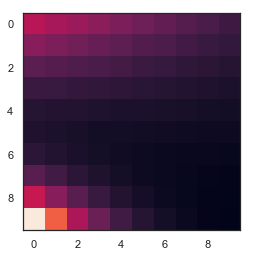

In [33]:
plt.imshow(MSELST[1])

Instead of sampling from a grid of $(I, K)$, here we do a random sampling of $(I, K)$.

In [29]:
def sampling_IK_optimization(sigma_lst, nstages, nsamples=100, maxiter=5):
    '''Perform optimization of (I, K), given parameters sigma'''
    durations = np.linspace(600, 1000, 5)
    ILST = np.zeros((len(sigma_lst), maxiter))
    KLST = np.zeros((len(sigma_lst), maxiter))

    # Do simulation several times to obtain error bars
    for id_s, sigma in enumerate(sigma_lst):
        print('*** sigma = ', sigma, ' ***')
        for niter in range(maxiter):
            print('    Running iteration #', niter)
            # For each iteration, re-pick list of I and K
            Klst = np.random.uniform(low=1, high=13, size=nsamples)
            initIlst = np.random.uniform(low=0.77, high=0.85, size=nsamples)

            mse_lst = np.zeros(nsamples)
            for i in range(nsamples):
                I = initIlst[i]
                K = Klst[i]
                mse_total = 0
                #print('        Doing time I = %f. K = %f' % (I, K))
                for k, dur in enumerate(durations):
                    #print('        Doing time #%d = %f. I = %f. K = %f\n' % (k, time, I, K))

                    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=100, nstages=nstages, 
                                                                           duration=dur, sigma=sigma, K=K, initI=I)

                    Ylst2 = np.array(ylst2)
                    times = get_times_lst_from_y(np.array(Ylst2))
                    times = times[(times > 0) & (times != np.inf)]

                    if len(times) == 0:
                        mse_total = np.inf
                        print('no time')
                        break
                    mse_total += np.sum((times * 10 - dur)**2)
                    #print('          times:', times)

                mse_lst[i] = np.sqrt(np.mean(mse_total))
                print('I = ', I, 'K = ', K, 'Total MSE = ', np.sqrt(np.mean(mse_total)))
                #bar.next()
            # Determine the arg-min of the list
            argmin = np.argsort(mse_lst)
            Kmin = Klst[argmin[0]]
            Imin = initIlst[argmin[0]]
            KLST[id_s][niter] = Kmin
            ILST[id_s][niter] = Imin
            print('        Kmin = ', Kmin, ', Imin =', Imin)
    return ILST, KLST

In [30]:
sampling_IK_optimization([0.001], 3, nsamples=100, maxiter=3)

*** sigma =  0.001  ***
    Running iteration # 0
no time
I =  0.8207362381332116 K =  2.8897140027423007 Total MSE =  inf
I =  0.827867087121878 K =  8.836943064831765 Total MSE =  4590.501061975697
I =  0.7904290749843061 K =  10.099303299910945 Total MSE =  2470.6274506691616
I =  0.8036867788580585 K =  11.649189206630526 Total MSE =  5390.324665546594
I =  0.8264718871816664 K =  12.604392654267306 Total MSE =  7871.537333964694
I =  0.8083795084787575 K =  8.812482318932132 Total MSE =  3079.1232518364704
I =  0.7797112846570153 K =  5.0503144252448955 Total MSE =  1081.6653826391969
no time
I =  0.8387362621151337 K =  5.560056095872454 Total MSE =  inf
I =  0.7773725679373782 K =  12.15215134775146 Total MSE =  2613.8477384882235
I =  0.8488002699203321 K =  10.003837438610756 Total MSE =  7072.701039913959
I =  0.7912654893080739 K =  9.614102146953629 Total MSE =  2203.156826011258
I =  0.7788630666419543 K =  4.208648345714242 Total MSE =  1397.211508684351
no time
I =  0.79

I =  0.7994818681075953 K =  10.565926977544423 Total MSE =  4078.210391826297
no time
I =  0.8233211753568525 K =  3.693729055815765 Total MSE =  inf
no time
I =  0.8079774419951465 K =  3.571850366456422 Total MSE =  inf
I =  0.7884472953430003 K =  10.326053299439806 Total MSE =  2320.8188210198573
I =  0.8498540396930796 K =  7.494511250294996 Total MSE =  3435.171029221107
I =  0.8454993644265416 K =  8.493187338211335 Total MSE =  5130.760177595519
I =  0.8444718362209803 K =  7.166393687801319 Total MSE =  2113.740759885185
I =  0.8033774635753499 K =  11.161078305514089 Total MSE =  5007.19482345155
I =  0.7752599408450089 K =  8.559441018309368 Total MSE =  361.24783736376884
no time
I =  0.8123529329394913 K =  4.808184612063002 Total MSE =  inf
I =  0.8224321846624111 K =  11.70511030859374 Total MSE =  7059.192588391395
I =  0.8260865669265214 K =  8.997461678206328 Total MSE =  4717.213160331002
I =  0.8234910638162845 K =  6.970544178513931 Total MSE =  850.7055894961546


I =  0.789040874996585 K =  10.169475906077714 Total MSE =  2305.2765560773832
no time
I =  0.8047989740838719 K =  5.613298534071928 Total MSE =  inf
I =  0.8154146266801774 K =  12.84482884413148 Total MSE =  7277.904918312687
no time
I =  0.816899952811216 K =  5.142228924510718 Total MSE =  inf
I =  0.7983178735904851 K =  9.540117322202367 Total MSE =  3001.0831378020835
I =  0.7743775771792563 K =  2.1752922058086135 Total MSE =  2911.133799741949
I =  0.7922980652579331 K =  7.357051937030027 Total MSE =  601.0823570859487
I =  0.8339940431936381 K =  7.947128733346466 Total MSE =  3440.4360188790024
I =  0.7739604641811175 K =  1.0699287748236102 Total MSE =  3365.754001706007
no time
I =  0.7918178034405304 K =  4.516789001566705 Total MSE =  inf
no time
I =  0.8455381143023601 K =  2.101657951243937 Total MSE =  inf
no time
I =  0.832645399639244 K =  4.56865247441425 Total MSE =  inf
I =  0.7934936799174261 K =  7.3332177408406904 Total MSE =  622.8964600958975
I =  0.821466

(array([[0.81826119, 0.77113688, 0.78904492]]),
 array([[7.20800681, 8.40806934, 7.59848878]]))

In [18]:
np.arange(3,12,4)

array([ 3,  7, 11])

In [ ]:
sigma_lst = np.linspace(0.001, 0.04, 6)

Iresults = []
Kresults = []

for i in [3]:
    print('### Number of iterations = ', i)
    a, b = sampling_IK_optimization(sigma_lst, i, nsamples=100, maxiter=10)
    Iresults.append(a)
    Kresults.append(b)

### Number of iterations =  3
*** sigma =  0.001  ***
    Running iteration # 0
        Kmin =  2.052992718661385 , Imin = 0.7963315687991683
    Running iteration # 1
        Kmin =  1.4679338954204182 , Imin = 0.7982904177063284
    Running iteration # 2
        Kmin =  1.0107315360142235 , Imin = 0.7995399637824394
    Running iteration # 3
        Kmin =  2.588595848198325 , Imin = 0.7993661566866924
    Running iteration # 4
        Kmin =  1.0686628559007567 , Imin = 0.790929980742183
    Running iteration # 5
        Kmin =  2.18286526726503 , Imin = 0.7938873856161875
    Running iteration # 6
        Kmin =  1.1403311981861424 , Imin = 0.7904359250315308
    Running iteration # 7
        Kmin =  2.5342229370945146 , Imin = 0.7949176854731017
    Running iteration # 8
        Kmin =  1.0124847699216954 , Imin = 0.7982983953720003
    Running iteration # 9
        Kmin =  2.506734178702668 , Imin = 0.7964717687322461
*** sigma =  0.008799999999999999  ***
    Running iteration #

In [37]:
combi_arr

array([[0.00782828, 0.77830044, 4.74505009],
       [0.01984848, 0.77827926, 1.86711584],
       [0.01949495, 0.78006121, 2.39174214],
       [0.00712121, 0.7790352 , 4.8065633 ],
       [0.01737374, 0.77928775, 2.01344899],
       [0.00747475, 0.77981176, 4.90009457],
       [0.01737374, 0.77963514, 1.41400684],
       [0.02126263, 0.77894898, 1.72886976],
       [0.02691919, 0.77608382, 1.6976787 ],
       [0.00959596, 0.77895049, 4.96373417],
       [0.0219697 , 0.77914476, 2.41438744]])

In [63]:
sigma_lst

array([0.001 , 0.0088, 0.0166, 0.0244, 0.0322, 0.04  ])

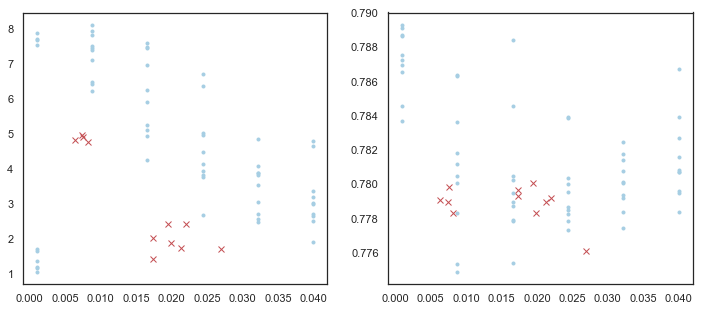

In [69]:
# Color schemes
colors = np.array([[166,206,227],
                [31,120,180],
                [178,223,138],
                [51,160,44],
                [251,154,153]]) / 255

# Load subject fit data
data = scipy.io.loadmat('PlotTools/IK_subject_fit_020519_thres0_7_constant_stage0_750ms_optimized3.mat')
combi_arr = data['combi_arr']

plt.figure(figsize=(12, 5))
# K plotting
plt.subplot(121)
plt.plot(combi_arr2[:,0], combi_arr[:,2], 'rx')

for i in range(1):
    plt.plot(sigma_lst, Kresults[i], '.', color=colors[i])

# I plotting
plt.subplot(122)

plt.plot(combi_arr2[:,0], combi_arr[:,1], 'rx')
for i in range(1):
    plt.plot(sigma_lst, Iresults[i], '.', color=colors[i])

In [56]:
combi_arr2 = combi_arr[:]
combi_arr2[0,:] = [0.00818, 0.778, 5.584]
combi_arr2[3,:] = [0.00636, 0.780, 6.077]
combi_arr2[5,:] = [0.00758, 0.780, 6.065]
combi_arr2[9,:] = [0.00742, 0.778, 5.717]

In [57]:
combi_arr2

array([[0.00818   , 0.778     , 5.584     ],
       [0.01984848, 0.77827926, 1.86711584],
       [0.01949495, 0.78006121, 2.39174214],
       [0.00636   , 0.78      , 6.077     ],
       [0.01737374, 0.77928775, 2.01344899],
       [0.00758   , 0.78      , 6.065     ],
       [0.01737374, 0.77963514, 1.41400684],
       [0.02126263, 0.77894898, 1.72886976],
       [0.02691919, 0.77608382, 1.6976787 ],
       [0.00742   , 0.778     , 5.717     ],
       [0.0219697 , 0.77914476, 2.41438744]])

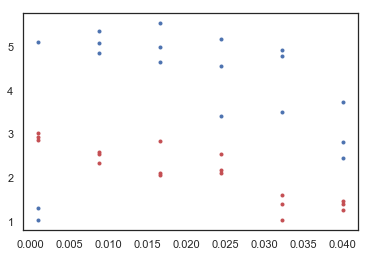

In [9]:
plt.plot(sigma_lst, Kresults[0], 'b.')
plt.plot(sigma_lst, Kresults[-1], 'r.')
#plt.plot(sigma_lst, Kresults[2], 'g.')
#plt.plot(sigma_lst, Kresults[-1], 'r.')

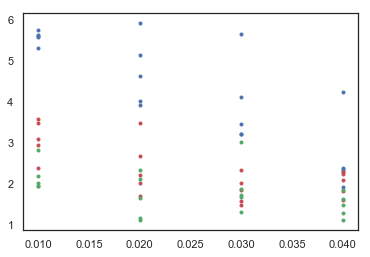

In [17]:
plt.plot(sigma_lst, Kresults[0], 'b.')
plt.plot(sigma_lst, Kresults[1], 'r.')
plt.plot(sigma_lst, Kresults[2], 'g.')
#plt.plot(sigma_lst, Kresults[-1], 'r.')

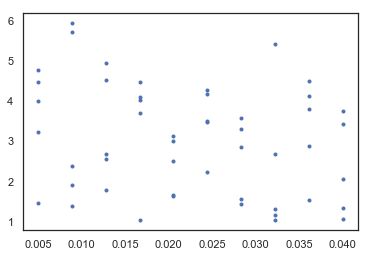

In [17]:
plt.plot(sigma_lst, KLST, 'b.')

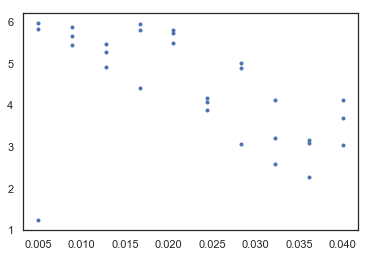

In [25]:
plt.plot(sigma_lst, KLST, 'b.')

In [ ]:
import time

### Doing random sampling for (I,K)

# Initiate the trial with a fixed current, trial duration is randomized in [600, 1000]
durations = np.linspace(600, 1000, 5)

sigma_lst = np.linspace(0.005, 0.04, 10)

nsamples = 100
nstages = 10

maxiter = 3
ILST = np.zeros((len(sigma_lst), maxiter))
KLST = np.zeros((len(sigma_lst), maxiter))

#Klst = np.linspace(0.5, 3.5, nsamples)

#bar = Bar('Processing', max=1000)
#bar.start()

start = time.time()

# Do simulation several times to obtain error bars
for id_s, sigma in enumerate(sigma_lst):
    print('*** sigma = ', sigma, ' ***')
    for niter in range(maxiter):
        print('    Running iteration #', niter)
        # For each iteration, re-pick list of I and K
        Klst = np.random.uniform(low=1, high=6, size=nsamples)
        initIlst = np.random.uniform(low=0.77, high=0.79, size=nsamples)
    
        mse_lst = np.zeros(nsamples)
        for i in range(nsamples):
            I = initIlst[i]
            K = Klst[i]
            mse_total = 0
            #print('        Doing time I = %f. K = %f' % (I, K))
            for k, dur in enumerate(durations):
                #print('        Doing time #%d = %f. I = %f. K = %f\n' % (k, time, I, K))

                ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=100, nstages=nstages, 
                                                                       duration=dur, sigma=sigma, K=K, initI=I)

                Ylst2 = np.array(ylst2)
                times = get_times_lst_from_y(np.array(Ylst2))
                times = times[(times > 0) & (times != np.inf)]

                mse_total += np.sum((times * 10 - dur)**2)

            mse_lst[i] = np.sqrt(np.mean(mse_total))
            #print('I = ', I, 'K = ', K, 'Total MSE = ', np.sqrt(np.mean(mse_total)))
            #bar.next()
        # Determine the arg-min of the list
        argmin = np.argsort(mse_lst)
        Kmin = Klst[argmin[0]]
        Imin = initIlst[argmin[0]]
        KLST[id_s][niter] = Kmin
        ILST[id_s][niter] = Imin
        print('        Kmin = ', Kmin, ', Imin =', Imin)

end = time.time()
print('Time taken = ', end - start)
# Save simulation results
#scipy.io.savemat('PlotTools/IK_optimization_data_I_0_78_1000trials.mat', {'initIlst': initIlst, 'Klst': Klst, 'KLST': KLST, 
#                                                  'ILST': ILST, 'sigma_lst': sigma_lst, 'PARAMS': PARAMS_DICT})
        
#bar.finish()
    
#plt.plot(initIlst, mse_lst)

*** sigma =  0.005  ***
    Running iteration # 0
        Kmin =  2.9756737834911386 , Imin = 0.7805323734141542
    Running iteration # 1
        Kmin =  3.8889902946802253 , Imin = 0.7821754462710986
    Running iteration # 2
        Kmin =  2.6181556944540483 , Imin = 0.7802945176936206
*** sigma =  0.008888888888888889  ***
    Running iteration # 0
        Kmin =  3.238908181153839 , Imin = 0.776205010753333
    Running iteration # 1
        Kmin =  3.5661133375027365 , Imin = 0.7866042658421407
    Running iteration # 2
        Kmin =  2.297364326199939 , Imin = 0.7768444786233386
*** sigma =  0.012777777777777779  ***
    Running iteration # 0
        Kmin =  2.4533558418962733 , Imin = 0.7811517579197104
    Running iteration # 1
        Kmin =  3.301470144112287 , Imin = 0.7789895258723817
    Running iteration # 2
        Kmin =  2.4762335547942667 , Imin = 0.7785702667443206
*** sigma =  0.016666666666666666  ***
    Running iteration # 0
        Kmin =  2.419460427301033 , 

Plotting the result of the simulation of optimized $(I, K)$ together with the fitted values.

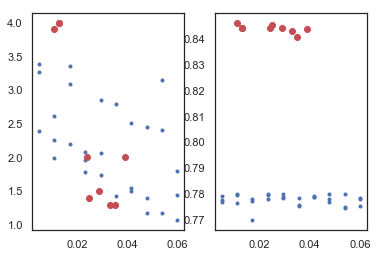

In [23]:
# Behavioral results
#sigma_behavior = [0.019, 0.019, 0.008, 0.02, 0.009, 0.01, 0.017, 0.0245, 0.026];
#I_behavior = [0.780, 0.779, 0.783, 0.780, 0.783, 0.782, 0.7805, 0.7792, 0.7773];
#K_behavior = [1.0, 1.0, 2.7, 1.0, 3.3, 2.7, 0.8, 0.8, 0.85];

# Params fit with threshold = 0.7
#sigma_behavior = [0.009, 0.018, 0.023, 0.007, 0.021, 0.009, 0.020, 0.025, 0.027];
#I_behavior = [0.781, 0.780, 0.780, 0.782, 0.781, 0.782, 0.781, 0.779, 0.777];
#K_behavior = [2.55, 1.10, 1.28, 2.76, 1.65, 2.89, 0.78, 0.67, 0.75];


# Params fit with threshold = 0.6
#sigma_behavior = [0.015, 0.026, 0.032, 0.012, 0.030, 0.013, 0.025, 0.035, 0.036];
#I_behavior = [0.848, 0.845, 0.844, 0.849, 0.845, 0.847, 0.845, 0.844, 0.841];
#K_behavior = [2.6, 1.0, 1.0, 2.7, 0.9, 2.7, 0.7, 0.7, 0.7];

# Fit with new model (with initial stage constant time)
sigma_behavior = [0.013, 0.024, 0.039, 0.011, 0.029, 0.013, 0.025, 0.033, 0.035];
I_behavior = [0.844, 0.844, 0.8435, 0.846, 0.844, 0.844, 0.845, 0.843, 0.8405];
K_behavior = [4.0, 2.0, 2.0, 3.9, 1.5, 4.0, 1.4, 1.3, 1.3];

plt.subplot(121)

for i, sigma in enumerate(sigma_lst):
    plt.plot(np.ones(maxiter) * sigma, KLST[i,:],'b.')
    
plt.plot(sigma_behavior, K_behavior, 'or')


plt.subplot('122')
plt.plot(sigma_behavior, I_behavior, 'or')

for i, sigma in enumerate(sigma_lst):
    plt.plot(np.ones(maxiter) * sigma, ILST[i,:],'b.')
    


In [200]:
scipy.io.savemat('PlotTools/IK_sim_relationship.mat', {'ILST': ILST, 'KLST': KLST,
                                            'sigma_lst': sigma_lst})

In [40]:
def find_min_indices(mat):
    '''Given a matrix, return the indices i, j such that mat[i][j] is the minimum entry'''
    idmin = np.argmin(mat)
    m, n = mat.shape
    
    return idmin // n, idmin % n

def find_min_IK(mat, Ivals, Kvals):
    '''Given the MSE matrix, find the I and K corresponding to the min MSE'''
    i, j = find_min_indices(mat)
    
    if i == 0 or i == len(Ivals) - 1:
        print('Warning: minimum at boundary for I')
    
    if j == 0 or j == len(Kvals) - 1:
        print('Warning: minimum at boundary for K')
    
    return Ivals[i], Kvals[j]
    



In [26]:
combi_arr

array([[0.00782828, 0.77830044, 4.74505009],
       [0.01984848, 0.77827926, 1.86711584],
       [0.01949495, 0.78006121, 2.39174214],
       [0.00712121, 0.7790352 , 4.8065633 ],
       [0.01737374, 0.77928775, 2.01344899],
       [0.00747475, 0.77981176, 4.90009457],
       [0.01737374, 0.77963514, 1.41400684],
       [0.02126263, 0.77894898, 1.72886976],
       [0.02691919, 0.77608382, 1.6976787 ],
       [0.00959596, 0.77895049, 4.96373417],
       [0.0219697 , 0.77914476, 2.41438744]])

Doing time # 0 = [600]
Doing time # 1 = [700]
Doing time # 2 = [800]
Doing time # 3 = [900]
Doing time # 4 = [1000]
Doing time # 0 = [600]
Doing time # 1 = [700]
Doing time # 2 = [800]
Doing time # 3 = [900]
Doing time # 4 = [1000]
RSG results:
Observed mean STD =  60.067726665412124
Simulated mean STD =  56.5466439521684
RSSG results:
Observed mean STD =  62.409422380986214
Simulated mean STD =  60.33757253781447


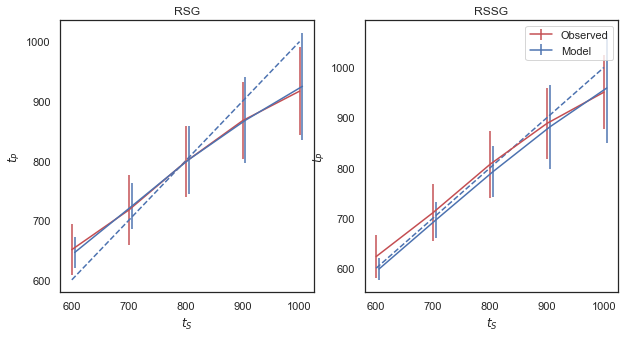

In [31]:
# Load data for subject GB (RSG/RSSG, Seth provided)
subject_file = all_subject_files[0]#'SWE_EKF_ObsAct0_20171105.mat'

sigma_val = 0.00782828
I_val = 0.77830044
K_val = 6


subject_data = scipy.io.loadmat(subject_file)
B = subject_data['B']
ts_vec = subject_data['ts_vec']
ta = subject_data['ta']
tss = subject_data['tss']
mtp_in = subject_data['mtp_in']
stdtp_in = subject_data['stdtp_in']

b = np.mean(B[:,0])

# Initiate the trial with a fixed current, trial duration is randomized in [400, 600]
durations = tss

prod_time_lst = []
prod_var_lst = []
prod_time_lst2 = []
prod_var_lst2 = []

#1,2,Go simulation
for i, time in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=3, duration=time, 
                                                           sigma=sigma_val, K=K_val, initI=I_val)

    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2))
    times = times[(times > 0) & (times != np.inf)]
    #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
    #print('Mean decision time is ', np.mean(times))
    prod_time_lst.append(np.mean(times))
    prod_var_lst.append(np.std(times))

#1,2,3,Go simulation
for i, time in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=4, duration=time, 
                                                           sigma=sigma_val, K=K_val, initI=I_val)

    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2))
    times = times[(times > 0) & (times != np.inf)]
    #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
    #print('Mean decision time is ', np.mean(times))
    prod_time_lst2.append(np.mean(times))
    prod_var_lst2.append(np.std(times))
    
# Plot the result, error bars represent standard deviation
plt.figure(figsize=(10, 5))
plt.subplot('121')
plt.errorbar(tss, mtp_in[:,0], stdtp_in[:,0], color='r', label='Observed')
#plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='g')

# Plot the result, error bars represent standard deviation
plt.plot(durations, durations, '--')
plt.errorbar(durations + 5, np.array(prod_time_lst) * 10, np.array(prod_var_lst) * 10, color='b', label='Model')
plt.xlabel('$t_S$')
plt.ylabel('$t_P$')
plt.title('RSG')

plt.subplot('122')
plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='r', label='Observed')
#plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='g')

# Plot the result, error bars represent standard deviation
plt.plot(durations, durations, '--')
plt.errorbar(durations + 5, np.array(prod_time_lst2) * 10, np.array(prod_var_lst2) * 10, color='b', label='Model')
plt.xlabel('$t_S$')
plt.ylabel('$t_P$')
plt.title('RSSG')
plt.legend()

print('RSG results:')
print('Observed mean STD = ', np.mean(stdtp_in[:,0]))
print('Simulated mean STD = ', np.mean(np.mean(prod_var_lst)* 10))

print('RSSG results:')
print('Observed mean STD = ', np.mean(stdtp_in[:,1]))
print('Simulated mean STD = ', np.mean(np.mean(prod_var_lst2)* 10))

## Behavior fitting protocol

The protocol has two parts: (1) Fitting $(I,K)$ and (2) Fitting $\sigma$. $(I, K)$ is fitted based on the mean of the distribution, while $\sigma$ is fitted based on the standard deviation.

### $(I,K)$ fitting

In [32]:
def do_IK_fitting(subject_file, sigmaval, nsamples=100, Klow=1, Khigh=3.5, Ilow=0.75, Ihigh=0.78,
                 print_every=10):
    '''Inputs:
    - subject_file: .mat file with the behavioral results of the subject
    - sigmaval: sigma value to be used
    - nsamples: number of random (I, K) combinations to sample
    - Klow, Khigh, Ilow, Ihigh: ranges of I and K for sampling
    
    Outputs:
    I, K: the optimal combination to minimize the mse between the mean simulated times
    and the mean behavioral times of the subject'''

    Klst = np.random.uniform(low=Klow, high=Khigh, size=nsamples)
    initIlst = np.random.uniform(low=Ilow, high=Ihigh, size=nsamples)

    # Load data for subject SWE(RSG/RSSG, Seth provided)
    swedata = scipy.io.loadmat(subject_file)
    B = swedata['B']
    ts_vec = swedata['ts_vec']
    ta = swedata['ta']
    tss = swedata['tss']
    mtp_in = swedata['mtp_in']
    stdtp_in = swedata['stdtp_in']

    target_time1 = mtp_in[:,0]
    target_time2 = mtp_in[:,1]

    b = np.mean(B[:,0])

    durations = tss
    errorlst = []

    for k in range(nsamples):
        Ival = initIlst[k]
        Kval = Klst[k]

        prod_time_lst, prod_var_lst, prod_time_lst2, prod_var_lst2 = [], [], [], []

        #1,2,Go simulation
        for i, dur in enumerate(durations):
            times = get_time_lst(ntrials=100, nstages=3, duration=dur, 
                             sigma=sigmaval, K=Kval, initI=Ival)
            prod_time_lst.append(np.mean(times))
            prod_var_lst.append(np.std(times))

        #1,2,3,Go simulation
        for i, dur in enumerate(durations):
            times = get_time_lst(ntrials=100, nstages=4, duration=dur, 
                             sigma=sigmaval, K=Kval, initI=Ival)
            prod_time_lst2.append(np.mean(times))
            prod_var_lst2.append(np.std(times))

        # Continue if there is a nan   
        error1 = (np.array(prod_time_lst) * 10 - target_time1) ** 2
        error2 = (np.array(prod_time_lst2) * 10 - target_time2) ** 2
        if np.sum(np.isnan(error1)) + np.sum(np.isnan(error2)) > 0:
            error = np.inf
            print('nan encountered')
        else:
        # Error function to minimize
            error = np.sum((np.array(prod_time_lst) * 10 - target_time1) ** 2) + \
                    np.sum((np.array(prod_time_lst2) * 10 - target_time2) ** 2)
        errorlst.append(error)

        if k % print_every == 0: # Print every 10 lines
            print('    I = %f, K = %f, error = %f' %(Ival, Kval, error))
    
    # Find the optimal (I, K)
    idx = np.argmin(errorlst)
    print('Optimal (I, K) = ', initIlst[idx], Klst[idx])
    return initIlst[idx], Klst[idx]

In [33]:
def do_sigma_fitting(subject_file, Ival, Kval, nsamples=100, low=0.001, high=0.05, print_every=10):
    '''Inputs:
    - subject_file: .mat file with the behavioral results of the subject
    - Ival, Kval: I and K values to be used
    - nsamples: number of random (I, K) combinations to sample
    - Klow, Khigh, Ilow, Ihigh: ranges of I and K for sampling
    
    Outputs:
    sigma: the optimal sigma to minimize the mse between the std simulated times
    and the std behavioral times of the subject'''

    sigmalst = np.linspace(low, high, nsamples)

    # Load data for subject SWE(RSG/RSSG, Seth provided)
    swedata = scipy.io.loadmat(subject_file)
    B = swedata['B']
    ts_vec = swedata['ts_vec']
    ta = swedata['ta']
    tss = swedata['tss']
    mtp_in = swedata['mtp_in']
    stdtp_in = swedata['stdtp_in']

    target_std1 = stdtp_in[:,0]
    target_std2 = stdtp_in[:,1]

    b = np.mean(B[:,0])

    durations = tss
    errorlst = []

    for k in range(nsamples):
        sigmaval = sigmalst[k]
        prod_time_lst, prod_var_lst, prod_time_lst2, prod_var_lst2 = [], [], [], []

        #1,2,Go simulation
        for i, dur in enumerate(durations):
            times = get_time_lst(ntrials=100, nstages=3, duration=dur, 
                             sigma=sigmaval, K=Kval, initI=Ival)
            prod_time_lst.append(np.mean(times))
            prod_var_lst.append(np.std(times))

        #1,2,3,Go simulation
        for i, dur in enumerate(durations):
            times = get_time_lst(ntrials=100, nstages=4, duration=dur, 
                             sigma=sigmaval, K=Kval, initI=Ival)
            prod_time_lst2.append(np.mean(times))
            prod_var_lst2.append(np.std(times))
            
        # Continue if there is a nan   
        error1 = (np.array(prod_var_lst) * 10 - target_std1) ** 2
        error2 = (np.array(prod_var_lst2) * 10 - target_std2) ** 2
        if np.sum(np.isnan(error1)) + np.sum(np.isnan(error2)) > 0:
            error = np.inf
            print('nan encountered')
        else:
            # Error function to minimize
            error = np.sum((np.array(prod_var_lst) * 10 - target_std1) ** 2) + \
                    np.sum((np.array(prod_var_lst2) * 10 - target_std2) ** 2)
        
        errorlst.append(error)

        if k % print_every == 0: # Print every 10 lines
            print('    sigma = %f, error = %f' %(sigmaval, error))
    
    # Find the optimal (I, K)
    idx = np.argmin(errorlst)
    print('Optimal sigma = ', sigmalst[idx])
    return sigmalst[idx]

In [68]:
Ival = 0.788803541303048 
Kval = 1.3483052257635142

sigmaval = 0.005
prod_time_lst, prod_var_lst, prod_time_lst2, prod_var_lst2 = [], [], [], []

target_std1 = stdtp_in[:,0]
target_std2 = stdtp_in[:,1]

#1,2,Go simulation
for i, dur in enumerate(durations):
    times = get_time_lst(ntrials=100, nstages=3, duration=dur, 
                     sigma=sigmaval, K=Kval, initI=Ival)
    print(times)
    print(np.mean(times))
    prod_time_lst.append(np.mean(times))
    prod_var_lst.append(np.std(times))

#1,2,3,Go simulation
for i, dur in enumerate(durations):
    times = get_time_lst(ntrials=100, nstages=4, duration=dur, 
                     sigma=sigmaval, K=Kval, initI=Ival)
    prod_time_lst2.append(np.mean(times))
    prod_var_lst2.append(np.std(times))

# Eliminate nan's    
error1 = (np.array(prod_va
                   r_lst) * 10 - target_std1) ** 2
error2 = (np.array(prod_var_lst2) * 10 - target_std2) ** 2
if np.sum(np.isnan(error1)) + np.sum(np.isnan(error2)) > 0:
    continue

# Error function to minimize
error = np.sum((np.array(prod_var_lst) * 10 - target_std1) ** 2) + \
        np.sum((np.array(prod_var_lst2) * 10 - target_std2) ** 2)

[117. 118. 119.]
118.0
[138. 128.]
133.0
[]
nan
[]
nan
[]
nan


C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [34]:
def subject_fitting(subject_file, sigma_init=0.02, nsamples=100, nsamples2=100, Klow=1, Khigh=3.5, Ilow=0.75, Ihigh=0.78, 
                    sigmalow=0.005, sigmahigh=0.04, print_every=10, niter=5):
    '''Optimize for the given subject file,
    Returns the fitted combination (sigma, I, K)'''
    sigmaval = sigma_init
    for i in range(niter):
        Ival, Kval = do_IK_fitting(subject_file, sigmaval=sigmaval, nsamples=nsamples, 
                                   Klow=Klow, Khigh=Khigh, Ilow=Ilow, Ihigh=Ihigh, print_every=print_every)
        sigmaval = do_sigma_fitting(subject_file, Ival=Ival, Kval=Kval, nsamples=nsamples2, 
                                    low=sigmalow, high=sigmahigh, print_every=print_every)
    return sigmaval, Ival, Kval
    
    

In [35]:
all_subject_files = ['SWE_EKF_ObsAct0_20171105.mat', 'CV_EKF_ObsAct0_20171105.mat',
                    'GB_EKF_ObsAct0_20171105.mat', 'LB_EKF_ObsAct0_20171105.mat',
                    'PG_EKF_ObsAct0_20171105.mat', 'SM_EKF_ObsAct0_20171105.mat',
                    'TA_EKF_ObsAct0_20171105.mat', 'VD_EKF_ObsAct0_20171105.mat',
                    'VR_EKF_ObsAct0_20171105.mat',
                    'SWE_EKF_ObsAct0_20171125.mat', 'GB_EKF_ObsAct0_20171125.mat']

In [40]:
combi_arr

array([[0.00782828, 0.77830044, 4.74505009],
       [0.01984848, 0.77827926, 1.86711584],
       [0.01949495, 0.78006121, 2.39174214],
       [0.00712121, 0.7790352 , 4.8065633 ],
       [0.01737374, 0.77928775, 2.01344899],
       [0.00747475, 0.77981176, 4.90009457],
       [0.01737374, 0.77963514, 1.41400684],
       [0.02126263, 0.77894898, 1.72886976],
       [0.02691919, 0.77608382, 1.6976787 ],
       [0.00959596, 0.77895049, 4.96373417],
       [0.0219697 , 0.77914476, 2.41438744]])

In [36]:
combi = subject_fitting(all_subject_files[0], nsamples=1000, nsamples2=100, Klow=4.0, Khigh=7.5, 
                            sigmalow=0.005, sigmahigh=0.02, Ilow=0.77, Ihigh=0.79, print_every=50)

    I = 0.782817, K = 4.986437, error = 8175.907008
    I = 0.783339, K = 7.254710, error = 9503.616711
    I = 0.772827, K = 7.431578, error = 10396.583041
    I = 0.774776, K = 4.847648, error = 37823.652493
    I = 0.789660, K = 6.800674, error = 9188.489655
    I = 0.781894, K = 5.937501, error = 5176.881420
    I = 0.774332, K = 6.964409, error = 19456.474638
    I = 0.788664, K = 6.530243, error = 11077.373977
    I = 0.770096, K = 5.035548, error = 71508.040652
    I = 0.775429, K = 7.134805, error = 9700.153047
    I = 0.788235, K = 5.096717, error = 45569.937958
    I = 0.771350, K = 5.747545, error = 47029.020858
    I = 0.774424, K = 5.077315, error = 34428.572202
    I = 0.774374, K = 5.185474, error = 31773.763748
    I = 0.771614, K = 7.249679, error = 10266.578711
    I = 0.771972, K = 5.982179, error = 43615.038995
    I = 0.775414, K = 6.412793, error = 12032.454990
    I = 0.772575, K = 4.444930, error = 57086.631077
    I = 0.786343, K = 5.742537, error = 16887.99758

In [41]:
combi = subject_fitting(all_subject_files[3], nsamples=1000, nsamples2=100, Klow=4.0, Khigh=7.5, 
                            sigmalow=0.005, sigmahigh=0.02, Ilow=0.77, Ihigh=0.79, print_every=50)

    I = 0.787566, K = 5.320910, error = 25353.338508
    I = 0.789086, K = 7.365057, error = 16923.025054
    I = 0.780501, K = 7.351038, error = 21897.083875
    I = 0.788876, K = 6.817603, error = 18785.545136
    I = 0.780733, K = 7.126390, error = 19341.553868
    I = 0.771642, K = 7.428776, error = 31860.657120
    I = 0.784125, K = 5.431661, error = 9776.307500
    I = 0.785498, K = 7.408567, error = 19474.770977
    I = 0.770259, K = 7.103029, error = 38337.827697
    I = 0.778858, K = 6.679775, error = 22282.975737
    I = 0.789063, K = 4.481737, error = 75793.684567
    I = 0.787417, K = 6.070668, error = 13720.779360
    I = 0.777365, K = 6.839863, error = 28837.740333
    I = 0.779708, K = 4.916896, error = 28900.398848
    I = 0.780794, K = 5.254060, error = 17974.574576
    I = 0.784369, K = 6.673983, error = 23645.277845
    I = 0.786569, K = 6.397273, error = 13212.319963
    I = 0.772951, K = 4.652385, error = 95292.407340
    I = 0.773292, K = 7.427104, error = 23565.8

In [42]:
combi = subject_fitting(all_subject_files[5], nsamples=1000, nsamples2=100, Klow=4.0, Khigh=7.5, 
                            sigmalow=0.005, sigmahigh=0.02, Ilow=0.77, Ihigh=0.79, print_every=50)

    I = 0.785824, K = 6.008874, error = 8430.104029
    I = 0.786160, K = 6.181563, error = 8267.567382
    I = 0.772423, K = 5.133115, error = 66335.818644
    I = 0.783789, K = 7.432367, error = 8192.154924
    I = 0.771203, K = 4.530957, error = 97610.391631
    I = 0.784446, K = 4.809731, error = 18258.640266
    I = 0.785003, K = 5.066436, error = 12698.818984
    I = 0.772045, K = 7.435483, error = 19027.278154
    I = 0.784848, K = 5.725206, error = 7863.262112
    I = 0.778008, K = 5.701657, error = 19936.029294
    I = 0.789452, K = 5.418728, error = 34091.518018
    I = 0.776774, K = 4.606827, error = 28230.049013
    I = 0.778946, K = 4.233680, error = 27245.573229
    I = 0.770446, K = 7.481863, error = 20256.641951
    I = 0.775399, K = 4.326029, error = 58366.071332
    I = 0.782769, K = 7.281511, error = 8456.894369
    I = 0.775909, K = 7.496562, error = 9232.657253
    I = 0.776153, K = 7.101695, error = 18088.728534
    I = 0.780776, K = 6.050703, error = 10038.018846

In [43]:
combi = subject_fitting(all_subject_files[9], nsamples=1000, nsamples2=100, Klow=4.0, Khigh=7.5, 
                            sigmalow=0.005, sigmahigh=0.02, Ilow=0.77, Ihigh=0.79, print_every=50)

    I = 0.773780, K = 5.579418, error = 31002.318504
    I = 0.781362, K = 6.958123, error = 11440.114010
    I = 0.770127, K = 5.803532, error = 43504.261096
    I = 0.782189, K = 7.312335, error = 13301.911100
    I = 0.784305, K = 5.884662, error = 8088.218909
    I = 0.781254, K = 4.400120, error = 10714.242663
    I = 0.785537, K = 5.206917, error = 28811.671173
    I = 0.784184, K = 6.460229, error = 7289.001866
    I = 0.777132, K = 7.286763, error = 9046.430971
    I = 0.787536, K = 6.810909, error = 10489.699841
    I = 0.773138, K = 4.374354, error = 68883.590136
    I = 0.773815, K = 4.487323, error = 55600.893318
    I = 0.776199, K = 4.480352, error = 28884.364250
    I = 0.787625, K = 6.446455, error = 15386.693035
    I = 0.784370, K = 4.841211, error = 25184.711586
    I = 0.772384, K = 5.443657, error = 48197.606259
    I = 0.776450, K = 6.434169, error = 16987.825603
    I = 0.778103, K = 5.296173, error = 8834.334040
    I = 0.774115, K = 6.203391, error = 21765.8059

In [90]:
#all_subject_files = ['SWE_EKF_ObsAct0_20171125.mat', 'GB_EKF_ObsAct0_20171125.mat']

combi_collection = []
for subject_file in all_subject_files:
    print(' ********* Doing subject file %s ************' % subject_file)
    combi = subject_fitting(subject_file, nsamples=1000, nsamples2=100, Klow=1.0, Khigh=5.0, 
                            Ilow=0.77, Ihigh=0.79, print_every=50)
    combi_collection.append(combi)

 ********* Doing subject file SWE_EKF_ObsAct0_20171105.mat ************
    I = 0.785573, K = 4.326345, error = 45751.452651
    I = 0.773337, K = 4.785570, error = 45937.825197
    I = 0.788951, K = 4.500109, error = 100795.540880
    I = 0.786233, K = 2.577218, error = 203128.572467
    I = 0.788778, K = 3.066610, error = 305962.559076
    I = 0.771167, K = 4.504359, error = 84187.859487
    I = 0.775163, K = 3.986227, error = 41518.453504
    I = 0.778980, K = 4.063347, error = 18184.136082
    I = 0.782625, K = 4.432111, error = 10544.577594
    I = 0.777746, K = 2.674747, error = 33925.521706
    I = 0.777661, K = 1.595200, error = 63129.628179
    I = 0.774741, K = 4.950654, error = 35479.996426
    I = 0.781491, K = 3.362190, error = 26355.809163
    I = 0.773168, K = 3.323957, error = 92716.246135
    I = 0.782102, K = 3.694432, error = 18113.315310
    I = 0.780332, K = 2.236770, error = 38935.173493
    I = 0.787058, K = 1.827182, error = 506633.039214
    I = 0.787391, K = 2

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan encountered
    I = 0.772150, K = 2.572975, error = 111260.175044
    I = 0.771153, K = 1.886773, error = 165163.687610
    I = 0.782936, K = 1.323872, error = 415442.909900
    I = 0.775019, K = 2.739492, error = 45584.252002
    I = 0.781541, K = 4.813373, error = 16540.876246
nan encountered
    I = 0.776072, K = 4.057261, error = 11965.112846
nan encountered
    I = 0.772623, K = 4.700784, error = 31649.755172
    I = 0.776779, K = 1.547507, error = 54770.958651
    I = 0.772396, K = 3.059428, error = 82830.907310
    I = 0.779065, K = 4.884761, error = 3109.067494
    I = 0.778616, K = 2.085877, error = 34259.119980
    I = 0.778866, K = 1.128262, error = 75566.345311
    I = 0.776566, K = 1.435991, error = 61717.238432
    I = 0.785515, K = 2.835115, error = 481247.171389
nan encountered
    I = 0.789268, K = 1.064771, error = inf
    I = 0.778338, K = 3.087205, error = 13417.597030
    I = 0.774200, K = 1.854781, error = 87597.119331
    I = 0.788928, K = 4.202346, error = 5

    I = 0.771977, K = 1.949739, error = 108681.449094
    I = 0.771701, K = 1.932387, error = 114592.920627
    I = 0.788630, K = 4.431266, error = 181046.691442
    I = 0.776975, K = 1.384267, error = 12055.135234
    I = 0.789858, K = 3.795332, error = 326468.914838
    I = 0.772009, K = 3.390612, error = 75036.318150
    I = 0.770934, K = 2.425284, error = 115339.229624
Optimal (I, K) =  0.7785442519095574 2.36605698649429
    sigma = 0.005000, error = 25864.788463
    sigma = 0.022677, error = 3818.438495
Optimal sigma =  0.021262626262626268
    I = 0.779465, K = 1.478867, error = 6085.116444
    I = 0.777017, K = 2.341631, error = 18872.998908
    I = 0.779645, K = 4.268810, error = 11330.579697
    I = 0.782447, K = 2.520579, error = 29501.869243
    I = 0.782881, K = 1.326653, error = 94869.031444
    I = 0.784086, K = 1.714083, error = 156592.445488
    I = 0.779349, K = 4.901558, error = 22411.357368
    I = 0.787148, K = 1.224423, error = 699787.339796
    I = 0.783445, K = 

    I = 0.788012, K = 3.647683, error = 123010.733163
    I = 0.788204, K = 1.535528, error = 508697.446085
    I = 0.784016, K = 2.797718, error = 49160.752285
    I = 0.789075, K = 2.809358, error = 294717.380220
    I = 0.772558, K = 4.814305, error = 48581.327342
    I = 0.786609, K = 3.365029, error = 96511.357356
    I = 0.785695, K = 3.198323, error = 70037.056432
    I = 0.787196, K = 1.353724, error = 456671.149605
    I = 0.770277, K = 2.109031, error = 139226.503534
    I = 0.788339, K = 1.465962, error = 569291.374294
    I = 0.770621, K = 4.144018, error = 87002.201698
    I = 0.771572, K = 4.667806, error = 55783.125200
    I = 0.787940, K = 4.785423, error = 46259.667600
    I = 0.781711, K = 4.062834, error = 10782.875747
    I = 0.780340, K = 2.541107, error = 1956.579328
    I = 0.770408, K = 2.551523, error = 122355.710723
    I = 0.780023, K = 2.066805, error = 5924.142339
Optimal (I, K) =  0.7800612072775213 2.391742136695186
    sigma = 0.005000, error = 34497.995

    I = 0.785188, K = 4.534131, error = 57871.652593
    I = 0.778311, K = 2.666022, error = 14232.339970
    I = 0.788486, K = 1.677533, error = 841958.641993
    I = 0.774680, K = 2.570987, error = 57106.305441
    I = 0.775147, K = 3.577056, error = 47683.767918
    I = 0.783936, K = 1.754833, error = 149252.259749
    I = 0.771152, K = 3.300677, error = 112007.215313
    I = 0.773173, K = 3.570782, error = 68766.870207
    I = 0.780296, K = 2.408110, error = 5845.561967
    I = 0.787045, K = 3.479132, error = 171781.453522
    I = 0.776660, K = 4.236494, error = 34645.824409
    I = 0.783967, K = 3.751554, error = 34351.224364
    I = 0.782459, K = 1.023452, error = 96529.965875
    I = 0.779881, K = 3.594348, error = 17062.714624
    I = 0.782579, K = 4.625881, error = 41817.281817
    I = 0.777617, K = 1.942646, error = 10881.563732
    I = 0.787982, K = 2.079971, error = 534278.788140
    I = 0.784063, K = 4.363772, error = 36116.559875
    I = 0.779196, K = 1.767447, error = 10

    I = 0.776755, K = 2.320503, error = 48855.426440
    I = 0.775298, K = 4.274101, error = 27944.922726
    I = 0.779055, K = 2.912373, error = 27919.394918
    I = 0.786461, K = 4.406376, error = 184711.523461
nan encountered
    I = 0.788140, K = 1.061459, error = 3817577.190089
    I = 0.783105, K = 3.753711, error = 76790.695956
    I = 0.786907, K = 2.900140, error = 788648.911446
nan encountered
    I = 0.775369, K = 2.062134, error = 71549.509607
nan encountered
    I = 0.785886, K = 1.329868, error = 1928936.819709
nan encountered
Optimal (I, K) =  0.7787822867839391 4.706681346697865
    sigma = 0.005000, error = 5117.079686
    sigma = 0.022677, error = 47232.683177
Optimal sigma =  0.009595959595959597
    I = 0.785281, K = 2.359215, error = 435251.330365
    I = 0.779175, K = 3.032081, error = 27961.714638
    I = 0.772707, K = 4.589069, error = 53208.766464
    I = 0.770745, K = 1.594299, error = 220287.441618
    I = 0.776056, K = 1.524668, error = 86772.287367
    I = 

    I = 0.772874, K = 2.541831, error = 134501.312557
    I = 0.786597, K = 2.441289, error = 252916.083108
    I = 0.776215, K = 4.581510, error = 71045.879473
    I = 0.770192, K = 1.810190, error = 247806.587085
Optimal (I, K) =  0.7795471601932579 1.279746569681607
    sigma = 0.005000, error = 26826.502195
    sigma = 0.022677, error = 1403.557706
Optimal sigma =  0.01666666666666667
    I = 0.776051, K = 1.186719, error = 57279.944802
    I = 0.787297, K = 1.697205, error = 664580.369836
    I = 0.770588, K = 4.132871, error = 146405.926870
    I = 0.779147, K = 4.846869, error = 48094.083599
    I = 0.779381, K = 1.734033, error = 4455.802954
    I = 0.781247, K = 2.920706, error = 14960.633555
    I = 0.771777, K = 2.465904, error = 165118.299287
    I = 0.772282, K = 1.157231, error = 187147.451659
    I = 0.780703, K = 4.038504, error = 35455.005753
    I = 0.783016, K = 1.904071, error = 61558.202650
    I = 0.785406, K = 2.656207, error = 143188.987898
    I = 0.787512, K =

    I = 0.781876, K = 3.569553, error = 15604.245414
    I = 0.774008, K = 3.066486, error = 50292.777477
    I = 0.783693, K = 2.380778, error = 67019.045859
    I = 0.779242, K = 2.130585, error = 2973.707321
    I = 0.774676, K = 3.145456, error = 43243.090530
    I = 0.775917, K = 3.043761, error = 26159.439825
    I = 0.778539, K = 2.950235, error = 7889.789143
    I = 0.778036, K = 3.150649, error = 13685.329150
    I = 0.778304, K = 1.741408, error = 2860.369315
    I = 0.785510, K = 2.260226, error = 136243.667732
    I = 0.771141, K = 1.938505, error = 112574.858626
    I = 0.778966, K = 4.218531, error = 14676.811586
    I = 0.787735, K = 1.626726, error = 453740.903485
    I = 0.771849, K = 4.366570, error = 64055.966841
    I = 0.779257, K = 1.535402, error = 1686.669878
Optimal (I, K) =  0.778948981907171 1.7288697643481723
    sigma = 0.005000, error = 40536.482488
    sigma = 0.022677, error = 2326.441783
Optimal sigma =  0.021262626262626268
 ********* Doing subject fil

    I = 0.789954, K = 2.549517, error = 653372.923246
    I = 0.784148, K = 4.823085, error = 19358.454055
    I = 0.786047, K = 1.038544, error = 623705.058703
Optimal (I, K) =  0.7801638121604926 4.67203869849264
    sigma = 0.005000, error = 6157.807270
    sigma = 0.022677, error = 45795.610755
Optimal sigma =  0.008535353535353537
    I = 0.770167, K = 2.990586, error = 139075.748093
nan encountered
    I = 0.789834, K = 4.784149, error = 320935.981327
    I = 0.784219, K = 2.457005, error = 318243.417419
    I = 0.776983, K = 4.974624, error = 4930.879518
    I = 0.778511, K = 4.473983, error = 3901.542064
    I = 0.777804, K = 1.443051, error = 52879.625609
    I = 0.777498, K = 1.846778, error = 44959.312338
    I = 0.777752, K = 4.074682, error = 7150.174841
    I = 0.784236, K = 1.428391, error = 640035.056530
    I = 0.775220, K = 3.488406, error = 30895.414877
nan encountered
    I = 0.778860, K = 2.016488, error = 38333.590720
    I = 0.785730, K = 3.954680, error = 199562

    I = 0.784831, K = 1.703088, error = 289258.241623
    I = 0.789634, K = 4.182349, error = 225872.537546
    I = 0.783454, K = 4.125736, error = 39796.051403
    I = 0.783021, K = 2.704277, error = 68634.568781
    I = 0.770018, K = 4.079576, error = 69998.072479
    I = 0.789215, K = 2.240866, error = 822611.394675
    I = 0.770490, K = 3.931211, error = 73538.548195
    I = 0.770331, K = 2.105970, error = 131372.506100
    I = 0.788151, K = 4.447525, error = 108942.693737
    I = 0.778491, K = 3.329687, error = 3620.240169
    I = 0.773600, K = 2.720186, error = 46607.579996
    I = 0.773883, K = 1.594618, error = 56093.589864
    I = 0.772805, K = 3.798973, error = 47820.092856
    I = 0.776160, K = 2.548559, error = 11805.368357
    I = 0.789877, K = 3.472481, error = 367857.362508
Optimal (I, K) =  0.7784184017792708 2.1109029435756894
    sigma = 0.005000, error = 37417.259027
    sigma = 0.022677, error = 1725.508564
Optimal sigma =  0.022323232323232328
    I = 0.783927, K =

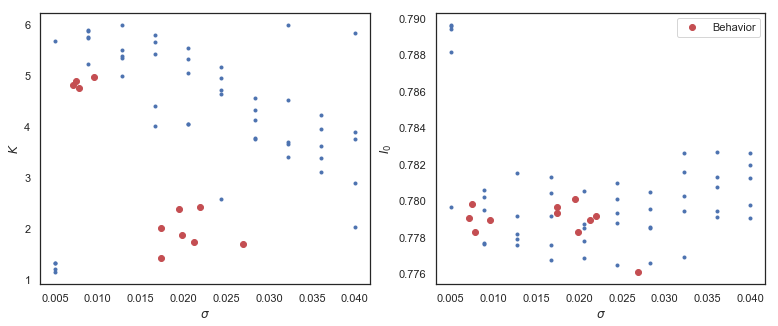

In [97]:
# Collate results
combi_arr = np.array(combi_collection)
sigmas = combi_arr[:,0]
Iarr = combi_arr[:,1]
Karr = combi_arr[:,2]

# Plot the results
plt.figure(figsize=(13,5))
plt.subplot(121)
# Simulation
for i, sigma in enumerate(sigma_lst):
    plt.plot(np.ones(maxiter) * sigma, KLST[i,:],'b.')
# Behavior
plt.plot(sigmas, Karr, 'or')

plt.xlabel(r'$\sigma$')
plt.ylabel(r'$K$')

plt.subplot('122')
# Simulation
for i, sigma in enumerate(sigma_lst):
    plt.plot(np.ones(maxiter) * sigma, ILST[i,:],'b.')
# Behavior
plt.plot(sigmas, Iarr, 'or', label='Behavior')

plt.xlabel(r'$\sigma$')
plt.ylabel(r'$I_0$')
plt.legend()

#plt.savefig('KI_relationship.pdf')

In [86]:
scipy.io.savemat('PlotTools/IK_subject_fit_020419_thres0_7_constant_stage0_750ms.mat', 
                 {'combi_arr': combi_arr, 'all_subject_files': all_subject_files})
scipy.io.savemat('PlotTools/IK_relationship_020419_constant_stage0_750ms.mat',
                {'ILST': ILST, 'KLST': KLST, 'sigma_lst': sigma_lst})

C:\Anaconda3\lib\site-packages\scipy\io\matlab\miobase.py:414: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  arr[empties] = ' '


## Plot model and subject BIAS, VAR, and RMSE

In [59]:
collated_bias_var = []

for i in range(len(all_subject_files)):
    print('Doing subject #%d of %d...' % (i + 1, len(all_subject_files)))
    # Load data for subject
    subject_file = all_subject_files[i]
    sigmaval = combi_arr2[i,0]
    Ival = combi_arr2[i,1]
    Kval = combi_arr2[i,2]

    swedata = scipy.io.loadmat(subject_file)
    B = swedata['B']
    ts_vec = swedata['ts_vec']
    ta = swedata['ta']
    tss = swedata['tss']
    mtp_in = swedata['mtp_in']
    stdtp_in = swedata['stdtp_in']

    target_time1 = mtp_in[:,0]
    target_time2 = mtp_in[:,1]

    b = np.mean(B[:,0])

    durations = tss
    errorlst = []

    prod_time_lst, prod_var_lst, prod_time_lst2, prod_var_lst2 = [], [], [], []

    #1,2,Go simulation
    for i, dur in enumerate(durations):
        times = get_time_lst(ntrials=100, nstages=3, duration=dur, 
                         sigma=sigmaval, K=Kval, initI=Ival)
        prod_time_lst.append(np.mean(times))
        prod_var_lst.append(np.std(times))

    #1,2,3,Go simulation
    for i, dur in enumerate(durations):
        times = get_time_lst(ntrials=100, nstages=4, duration=dur, 
                         sigma=sigmaval, K=Kval, initI=Ival)
        prod_time_lst2.append(np.mean(times))
        prod_var_lst2.append(np.std(times))

    # Bias
    bias_model1 = np.sum((np.array(prod_time_lst) * 10 - tss.T)**2) / len(tss)
    bias_subject1 = np.sum((target_time1 - tss.T)**2) / len(tss)
    bias_model2 = np.sum((np.array(prod_time_lst2) * 10 - tss.T)**2) / len(tss)
    bias_subject2 = np.sum((target_time2 - tss.T)**2) / len(tss)

    # Variance
    var_model1 = np.sum((np.array(prod_var_lst) * 10)**2) / len(tss)
    var_subject1 = np.sum(stdtp_in[:,0]**2) / len(tss)
    var_model2 = np.sum((np.array(prod_var_lst2) * 10)**2) / len(tss)
    var_subject2 = np.sum(stdtp_in[:,1]**2) / len(tss)
    
    # Collate
    collated_bias_var.append((bias_model1, bias_subject1, bias_model2, bias_subject2,
                             var_model1, var_subject1, var_model2, var_subject2))

collated_bias_var = np.sqrt(np.array(collated_bias_var))

Doing subject #1 of 11...
Doing subject #2 of 11...
Doing subject #3 of 11...
Doing subject #4 of 11...
Doing subject #5 of 11...
Doing subject #6 of 11...
Doing subject #7 of 11...
Doing subject #8 of 11...
Doing subject #9 of 11...
Doing subject #10 of 11...
Doing subject #11 of 11...


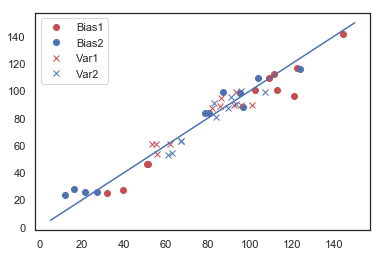

In [61]:
# Plot bias and variance
plt.plot(collated_bias_var[:,0], collated_bias_var[:,1], 'ro', label='Bias1')
plt.plot(collated_bias_var[:,2], collated_bias_var[:,3], 'bo', label='Bias2')
plt.plot(collated_bias_var[:,4], collated_bias_var[:,5], 'rx', label='Var1')
plt.plot(collated_bias_var[:,6], collated_bias_var[:,7], 'bx', label='Var2')
plt.plot([5,150], [5, 150])
plt.legend()

In [64]:
# Save collated bias and variance
suffix = '020519_thres0_7_constant_stage0_750ms_optimized3_Krange1to7.mat'
scipy.io.savemat('PlotTools/IK_subject_fit_' + suffix, 
                 {'combi_arr': combi_arr2, 'all_subject_files': all_subject_files})
scipy.io.savemat('PlotTools/IK_relationship_multi_' + suffix,
                {'Iresults': Iresults, 'Kresults': Kresults, 'sigma_lst': sigma_lst})
scipy.io.savemat('PlotTools/biasvar_' + suffix, 
                 {'collated_bias_var': collated_bias_var, 'all_subject_files': all_subject_files})

C:\Anaconda3\lib\site-packages\scipy\io\matlab\miobase.py:414: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  arr[empties] = ' '


In [62]:
Iresults

[array([[0.78809019, 0.78884011, 0.78673917, 0.78835308, 0.78998716,
         0.7872017 , 0.78831219, 0.78965924, 0.78987637, 0.78751713],
        [0.77876566, 0.7780018 , 0.78034834, 0.78100918, 0.77925654,
         0.7803639 , 0.77809483, 0.77711177, 0.77947069, 0.78027868],
        [0.78002692, 0.7770923 , 0.7785422 , 0.77912482, 0.779219  ,
         0.78007803, 0.77678187, 0.77891956, 0.78097363, 0.78085924],
        [0.78174379, 0.77876805, 0.77882841, 0.77921543, 0.77939682,
         0.77878389, 0.78279536, 0.78107547, 0.78052628, 0.78093314],
        [0.77940451, 0.78033891, 0.78013772, 0.78238905, 0.77953525,
         0.78305766, 0.78372731, 0.77986596, 0.77773973, 0.78352933],
        [0.78052154, 0.78090044, 0.78038872, 0.78520526, 0.78139775,
         0.77789012, 0.77905976, 0.77982284, 0.78101287, 0.78034774]]),
 array([[0.78140293, 0.78440769, 0.7814341 , 0.78167253, 0.78306761,
         0.78194615, 0.78165691, 0.78080198, 0.78094916, 0.78092764],
        [0.77704907, 0.77